<a href="https://colab.research.google.com/github/ehsan-abdi/customer-segmentation-unsupervised-ml/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Using Unsupervised Learning on Large-Scale E-Commerce Data

## Executive Summary
This notebook applies unsupervised machine learning techniques to segment customers based on purchasing behaviour using a large real-world e-commerce dataset. After feature engineering and clustering analysis, five interpretable customer segments are identified, differing primarily in customer value, engagement, and demographic characteristics. While customer behaviour forms a dense and continuous space with overlapping segments, the resulting clusters provide a practical foundation for targeted marketing and customer retention strategies.

---

## Objective
The objective of this analysis is to identify and interpret customer segments from transactional and demographic data using unsupervised learning, with the aim of supporting data-informed marketing and customer retention decisions.

---

## Dataset Overview
The analysis is based on a real-world e-commerce dataset containing approximately 950,000 transaction records from around 68,000 unique customers across 47 countries. The data spans multiple years and includes common real-world challenges such as missing values, duplicate records, and skewed feature distributions. Transaction-level data is aggregated to the customer level to enable behaviour-based segmentation.

---

## Approach
The analysis follows an end-to-end data science workflow:
- Exploratory analysis to understand customer behaviour and data quality
- Feature engineering to derive customer-level engagement and value metrics
- Unsupervised clustering using K-Means, with cluster selection informed by multiple evaluation techniques
- Qualitative assessment of cluster structure and interpretability using dimensionality reduction

The focus is on producing interpretable segments while recognising the assumptions and limitations inherent to unsupervised learning.


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
# Set random seed
SEED = 42

# Reference date for time-based features (dataset end date)
REFERENCE_DATE = pd.Timestamp('2016-12-30')

# Load Data

In [ ]:
# Load data
url = 'https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip'
data = pd.read_csv(url)


# Initial Data Inspection

In [ ]:
print(f'Shape of the dataset: {data.shape}\n')
data.head()


Shape of the dataset: (951669, 20)



,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


In [ ]:
# Create summary dataframe
summary = pd.DataFrame({
    'dtype': data.dtypes,
    'non_null_count': data.notna().sum(),
    'missing_count': data.isna().sum(),
    'unique_count': data.nunique()
})

# Display the summary
summary

,dtype,non_null_count,missing_count,unique_count
Quantity,int64,951669,0,10
City,object,951534,135,10505
Continent,object,951669,0,5
Postal_Code,object,947953,3716,19339
State_Province,object,834477,117192,271
Order_Date,object,951669,0,1825
Delivery_Date,object,951669,0,1840
Total Revenue,object,951669,0,6894
Unit Cost,object,951669,0,1883
Discount,object,951669,0,5


In [ ]:
# Check how many duplicated rows exist in the dataset
duplicate_count = data.duplicated().sum()

# Report number of duplicated samples
print(f"Number of duplicated samples in the dataset: {duplicate_count}")


Number of duplicated samples in the dataset: 21


## Summary

- Dataset contains **951,669 entries** and **20 columns**.
- There are **68,300 unique customers** and **747,953 unique orders**.
- **Missing data** exists in customer address details, including:
  - City
  - Postal Code
  - State/Province
- There are **21 duplicate rows** in the dataset.
- The following **monetary columns are stored as strings** and need conversion to numeric:
  - Total Revenue
  - Unit Cost
  - Profit
- The following **date columns are stored as strings** and need conversion to datetime:
  - Order Date
  - Delivery Date
  - Customer Birthdate

# Feature Engineering

This section focuses on preparing the dataset for customer-level analysis and deriving meaningful features for segmentation.

**Preprocessing**
- Remove duplicate entries
- Convert currency fields to numeric types and date fields to datetime

**Customer Metric Creation**
- Aggregate transaction-level data to the customer level
- Engineer key customer metrics, including:
  - Frequency
  - Recency
  - Customer Lifetime Value (CLV)
  - Average Unit Cost
  - Customer Age

## Preprocessing: remove duplicate entries

In [ ]:
# Remove duplicate entries
data.drop_duplicates(inplace=True, ignore_index=True)

## Preprocessing: data type conversion

In this section:
* **Currency columns** stored as strings are converted to floats; and
* **Date columns** stored as strings are converted to datetime objects.

In [ ]:
def currency_to_float(df, columns):
    """
    Convert multiple currency string columns to numeric floats.

    Handles:
    - Positive amounts: "$99.64" -> 99.64
    - Negative amounts: "($99.64)" -> -99.64
    - Removes $, commas, spaces, and parentheses
    - Raises error if conversion fails

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str
        Columns to convert.

    Returns
    -------
    pd.DataFrame
        DataFrame with specified columns converted to floats.
    """
    df_clean = df.copy()

    for col in columns:
        # Remove $ and commas
        cleaned = df_clean[col].astype(str).str.replace(r'[$,]', '', regex=True).str.strip()

        # Remove parentheses and handle negative values
        cleaned = cleaned.apply(lambda x: -float(x.replace('(', '').replace(')', ''))
                                if '(' in x else x)

        # Convert to float, raise error if invalid
        df_clean[col] = pd.to_numeric(cleaned, errors='raise')

    return df_clean

In [ ]:
def string_to_datetime(df, columns, date_format='%d%b%Y', errors='raise'):
    """
    Convert multiple string columns to datetime.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    columns : list of str
        Column names to convert
    date_format : str
        Format of the input dates
    errors : str
        How to handle errors: 'raise' or 'coerce'

    Returns
    -------
    pd.DataFrame
        DataFrame with specified columns converted to datetime
    """
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = pd.to_datetime(df_copy[col], format=date_format, errors=errors)
    return df_copy

In [ ]:
# Convert currency string columns to numeric floats
currency_cols = ['Profit', 'Total Revenue', 'Unit Cost']
data_typed = currency_to_float(data, currency_cols)

# Convert date string columns to datetime
date_cols = ['Customer_BirthDate', 'Order_Date', 'Delivery_Date']
data_typed = string_to_datetime(data_typed, date_cols)

data_typed.head()

,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,2012-01-01,2012-01-07,28.5,9.1,.,Internet Sale,Australia,1978-05-08,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,1.2,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,2012-01-01,2012-01-04,113.4,56.9,.,Internet Sale,Australia,1978-12-13,Orion Club Gold members,Orion Club Gold members high activity,1230000204,-0.4,3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,2012-01-01,2012-01-04,41.0,18.5,.,Internet Sale,Australia,1978-12-13,Orion Club Gold members,Orion Club Gold members high activity,1230000204,4.0,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,2012-01-01,2012-01-03,35.2,29.6,.,Internet Sale,Australia,1997-06-22,Orion Club Gold members,Orion Club Gold members high activity,1230000268,5.6,2,0,71727
4,1,Montréal,North America,NaN,Quebec,2012-01-01,2012-01-04,24.7,23.6,.,Internet Sale,Canada,1978-01-28,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,1.1,3,99,74503


In [ ]:
# Inspect data types after conversion
data_typed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951648 entries, 0 to 951647
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Quantity              951648 non-null  int64         
 1   City                  951513 non-null  object        
 2   Continent             951648 non-null  object        
 3   Postal_Code           947932 non-null  object        
 4   State_Province        834456 non-null  object        
 5   Order_Date            951648 non-null  datetime64[ns]
 6   Delivery_Date         951648 non-null  datetime64[ns]
 7   Total Revenue         951648 non-null  float64       
 8   Unit Cost             951648 non-null  float64       
 9   Discount              951648 non-null  object        
 10  OrderTypeLabel        951648 non-null  object        
 11  CustomerCountryLabel  951648 non-null  object        
 12  Customer_BirthDate    951648 non-null  datetime64[ns]
 13 

## Create Customer Metrics

The transaction-level dataset is aggregated to the customer level to derive key metrics that capture purchasing behaviour and customer characteristics over the observed period.

The following customer metrics are created:

- **Frequency**: Number of unique orders placed by the customer
- **Recency**: Number of days since the customer's most recent order
- **Customer Lifetime Value (CLV)**: Total revenue generated by the customer during the observed period  
- **Average Unit Cost**: Mean unit cost of items purchased, reflecting price preference   
- **Customer Age**: Age of the customer (in years) at the reference date

In [ ]:
# Compute customer-level metrics from transaction data
customer_metrics = (
    data_typed
    .groupby('Customer ID')
    .agg(
        Frequency=('Order ID', 'nunique'),
        CLV=('Total Revenue', 'sum'),
        Avg_Unit_Cost=('Unit Cost', 'mean'),
        Recency=('Order_Date', lambda x: (REFERENCE_DATE - x.max()).days),
        Customer_Age=('Customer_BirthDate', lambda x: (REFERENCE_DATE - x.iloc[0]).days // 365),
    )
    .reset_index()
)

In [ ]:
# Preview customer-level metrics
customer_metrics.head().round(2)


,Customer ID,Frequency,CLV,Avg_Unit_Cost,Recency,Customer_Age
0,1,28,4322.70,89.62,17,63
1,3,14,2821.00,90.50,124,33
2,4,8,782.67,37.20,1108,33
3,5,15,2810.98,107.95,5,28
4,6,13,1604.58,52.53,192,58


# Exploratory Data Analysis

This section explores the engineered customer metrics to understand their statistical properties, distributions, and potential outliers.

The following analyses are performed:
- Descriptive statistical analysis
- Examination of feature distributions
- Outlier detection using the Interquartile Range (IQR) method


In [ ]:
# Drop 'Customer_ID' column
X = customer_metrics.drop(columns=['Customer ID'])

# Display data types and non-null counts for customer metrics
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68300 entries, 0 to 68299
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Frequency      68300 non-null  int64  
 1   CLV            68300 non-null  float64
 2   Avg_Unit_Cost  68300 non-null  float64
 3   Recency        68300 non-null  int64  
 4   Customer_Age   68300 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 2.6 MB


In [ ]:
# Summary statistics of customer metrics
X.describe().round(2)


,Frequency,CLV,Avg_Unit_Cost,Recency,Customer_Age
count,68300.00,68300.00,68300.00,68300.00,68300.00
mean,10.95,1950.15,78.90,367.66,43.13
std,8.77,1719.92,38.01,414.51,17.49
min,1.00,0.63,0.50,0.00,19.00
25%,5.00,696.00,57.58,45.00,28.00
50%,9.00,1497.40,73.45,190.00,43.00
75%,15.00,2709.84,92.52,539.25,58.00
max,101.00,18860.96,1463.50,1824.00,74.00


In [ ]:
def plot_feature_distributions(X, bins=20, figsize=(15, 8)):
    """
    Plot histograms for all features in a dataset to inspect their distributions.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix containing numerical variables to be visualized.
    bins : int, optional (default=20)
        Number of bins to use for each histogram.
    figsize : tuple, optional (default=(15, 8))
        Size of the matplotlib figure.
    """

    # Retrieve feature names from the DataFrame
    features = X.columns

    # Create a 2x3 grid of subplots for histogram visualization
    fig, axes = plt.subplots(2, 3, figsize=figsize)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Plot a histogram for each feature
    for i, feature in enumerate(features):
        axes[i].hist(X[feature], bins=bins, color='turquoise', edgecolor='black')
        axes[i].set_title(f'Histogram of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplot(s) to keep the layout clean
    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)

    # Adjust spacing between subplots and display the figure
    plt.tight_layout()
    plt.show()


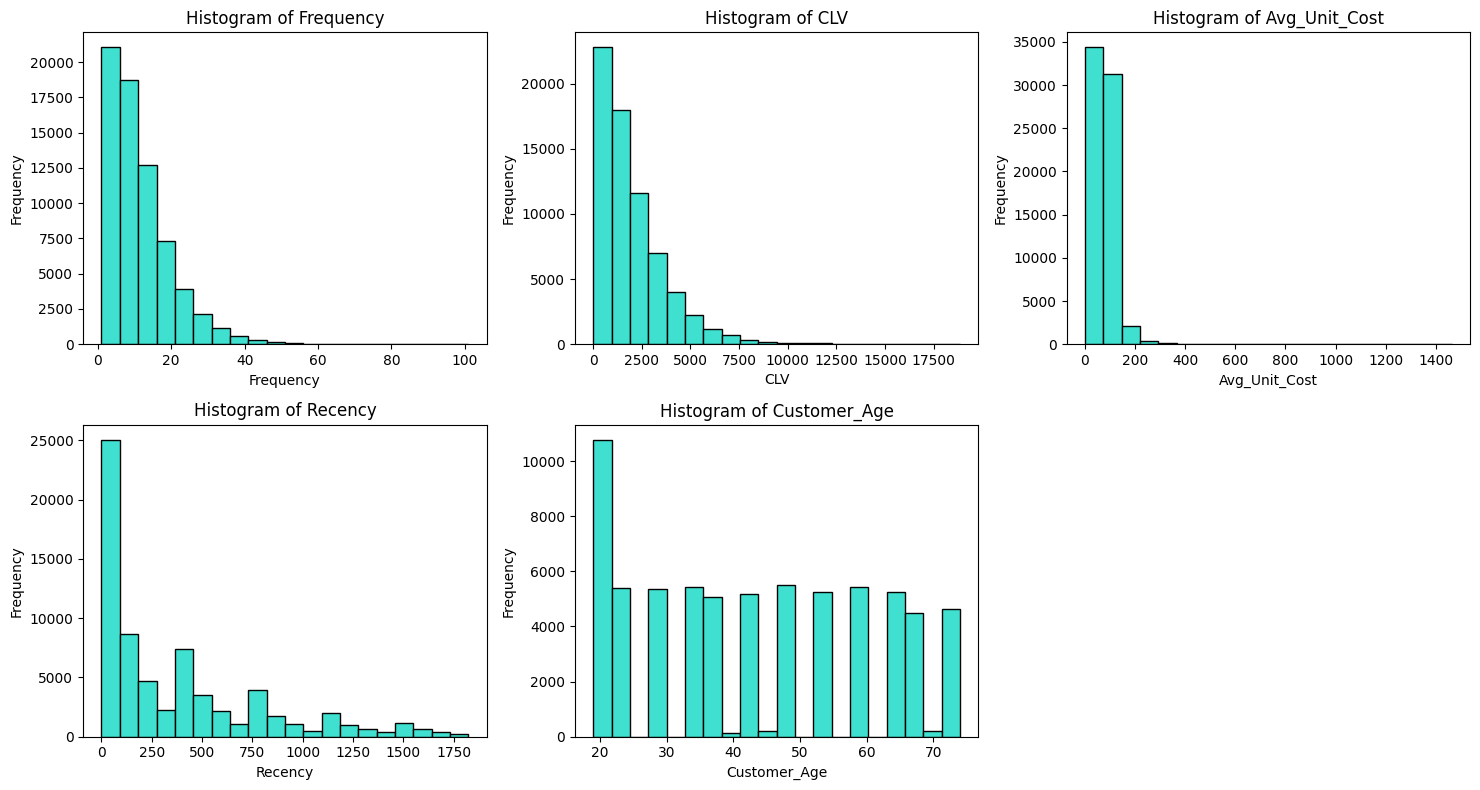

In [ ]:
# Plot the distribution of features
plot_feature_distributions(X)


In [ ]:
def plot_feature_boxplots(X, figsize=(15, 8)):
    """
    Plot boxplots for all features in a dataset to visualize distributions
    and identify potential outliers.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix containing numerical variables to be visualized.
    figsize : tuple, optional (default=(15, 8))
        Size of the matplotlib figure.
    """

    # Retrieve feature names from the DataFrame
    features = X.columns

    # Create a 2x3 grid of subplots for boxplot visualization
    fig, axes = plt.subplots(2, 3, figsize=figsize)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Plot a boxplot for each feature
    for i, feature in enumerate(features):
        sns.boxplot(x=X[feature], ax=axes[i], color='turquoise')
        axes[i].set_title(f'Boxplot of {feature}')

    # Hide any unused subplot(s) to keep the layout clean
    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)

    # Adjust spacing between subplots and display the figure
    plt.tight_layout()
    plt.show()


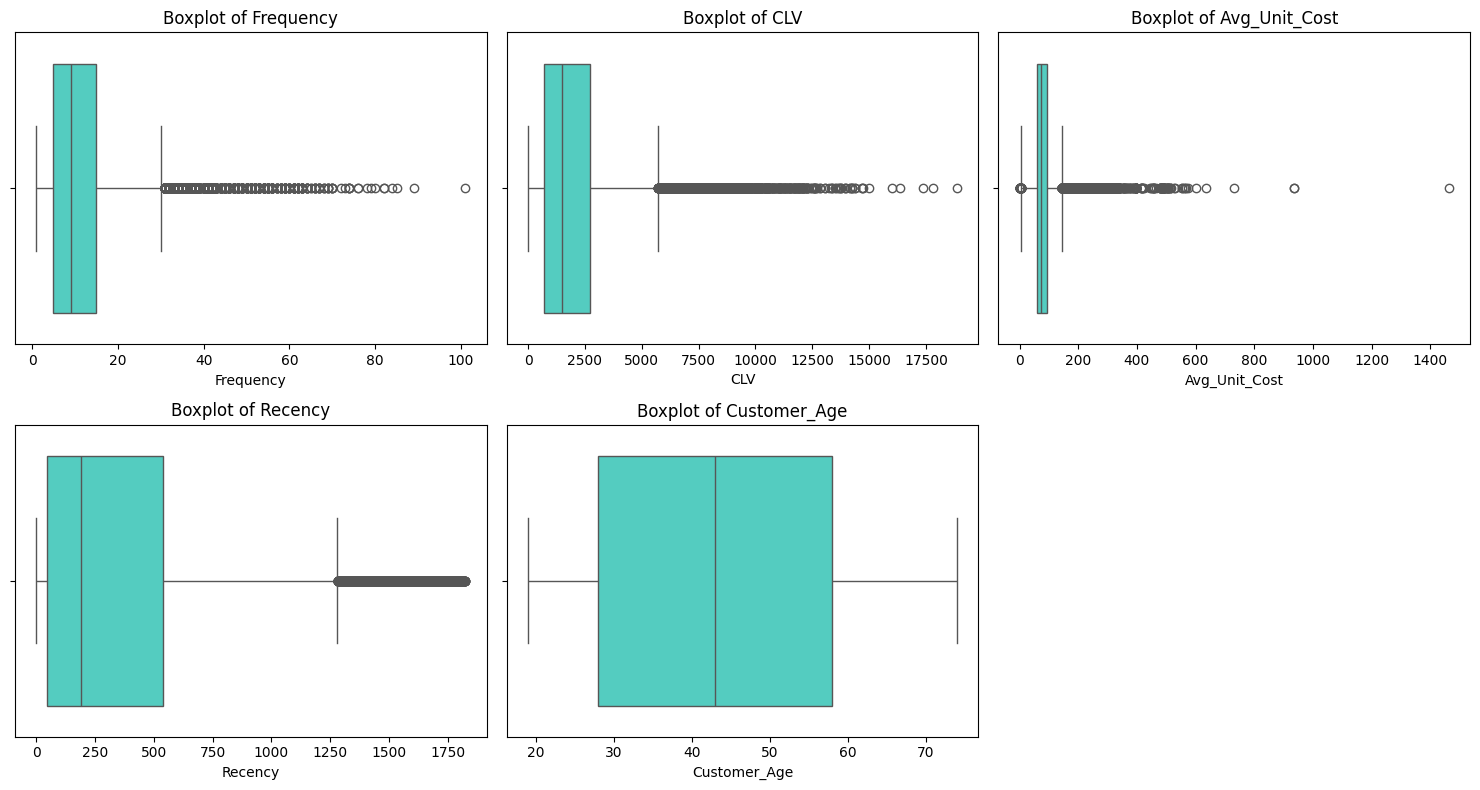

In [ ]:
# Boxplots
plot_feature_boxplots(X)


In [ ]:
def iqr_outlier_detection(X):
    """
    Detect anomalies for each feature using the IQR (Interquartile Range) method.

    For each feature in the provided list:
      - Computes Q1 (25th percentile) and Q3 (75th percentile)
      - Calculates the IQR (Q3 - Q1)
      - Determines the lower and upper Tukey fences (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
      - Prints the number and percentage of outliers for each feature

    Parameters
    ----------
    X : pandas.DataFrame
        The input dataframe.

    Returns
    -------
    None
        Prints outlier statistics for each feature.
    """
    # Retrieve feature names from the DataFrame
    features = X.columns

    results = []

    for feature in features:
        # Compute quartiles and IQR
        Q1, Q3 = X[feature].quantile([0.25, 0.75])
        IQR = Q3 - Q1

        # Compute upper and lower whiskers
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR

        # Count outliers and their percentage
        outlier_count = (
            (X[feature] < lower_fence) | (X[feature] > upper_fence)
        ).sum()
        percent = 100 * outlier_count / len(X)

        # Store results for this feature
        results.append({
            'Feature': feature,
            'Outliers': outlier_count,
            'Percent': f"{percent:.1f}%"
        })

    # Display outlier statistics
    results_df = pd.DataFrame(results)
    display(results_df)


In [ ]:
# Run the IQR outlier detection function
iqr_outlier_detection(X)


,Feature,Outliers,Percent
0,Frequency,2481,3.6%
1,CLV,2590,3.8%
2,Avg_Unit_Cost,2889,4.2%
3,Recency,3361,4.9%
4,Customer_Age,0,0.0%


## Summary

- The dataset contains 68,300 customers with five numerical features.

- The dataset is primarily **right-skewed**, with most customers showing low Frequency, Average Unit Cost, and CLV, while **Customer Age** is distributed **uniformly** across the 20-70 range.

- IQR analysis shows a **low proportion of outliers (<5%)** for all behavioral and financial metrics, and none for Customer Age.

# Customer Clustering

This section performs customer segmentation using clustering techniques. The main steps include:

- **Feature Transformation**: Prepare and scale features for clustering.
- **Elbow Method**: Identify the optimal number of clusters by analyzing the within-cluster variance.  
- **Silhouette Score**: Assess cluster quality and separation to help select the best number of clusters.  
- **Hierarchical Clustering and Dendrogram**: Examine hierarchical relationships and visualize cluster structure to inform the choice of cluster numbers.
- **Choice of Cluster Numbers**: Decide on the optimal number of clusters using the above methods.
- **K-Means Clustering**: Segment customers into clusters using the selected number of clusters.


## Feature Transformation
This subsection applies the following steps to prepare features for clustering:

- **Square Root Transformation**: Reduce right skewness in selected features.  
- **Standardization**: Scale features to have comparable ranges.  
- **Distribution Check**: Visualize transformed features to confirm effectiveness.

In [ ]:
# Apply feature transformation

# List of skewed features identified in the histograms
skewed_cols = ['Frequency', 'Avg_Unit_Cost', 'CLV', 'Recency']

# Apply square root Transformation
X_transformed = X.copy()
X_transformed[skewed_cols] = X_transformed[skewed_cols].apply(np.sqrt)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

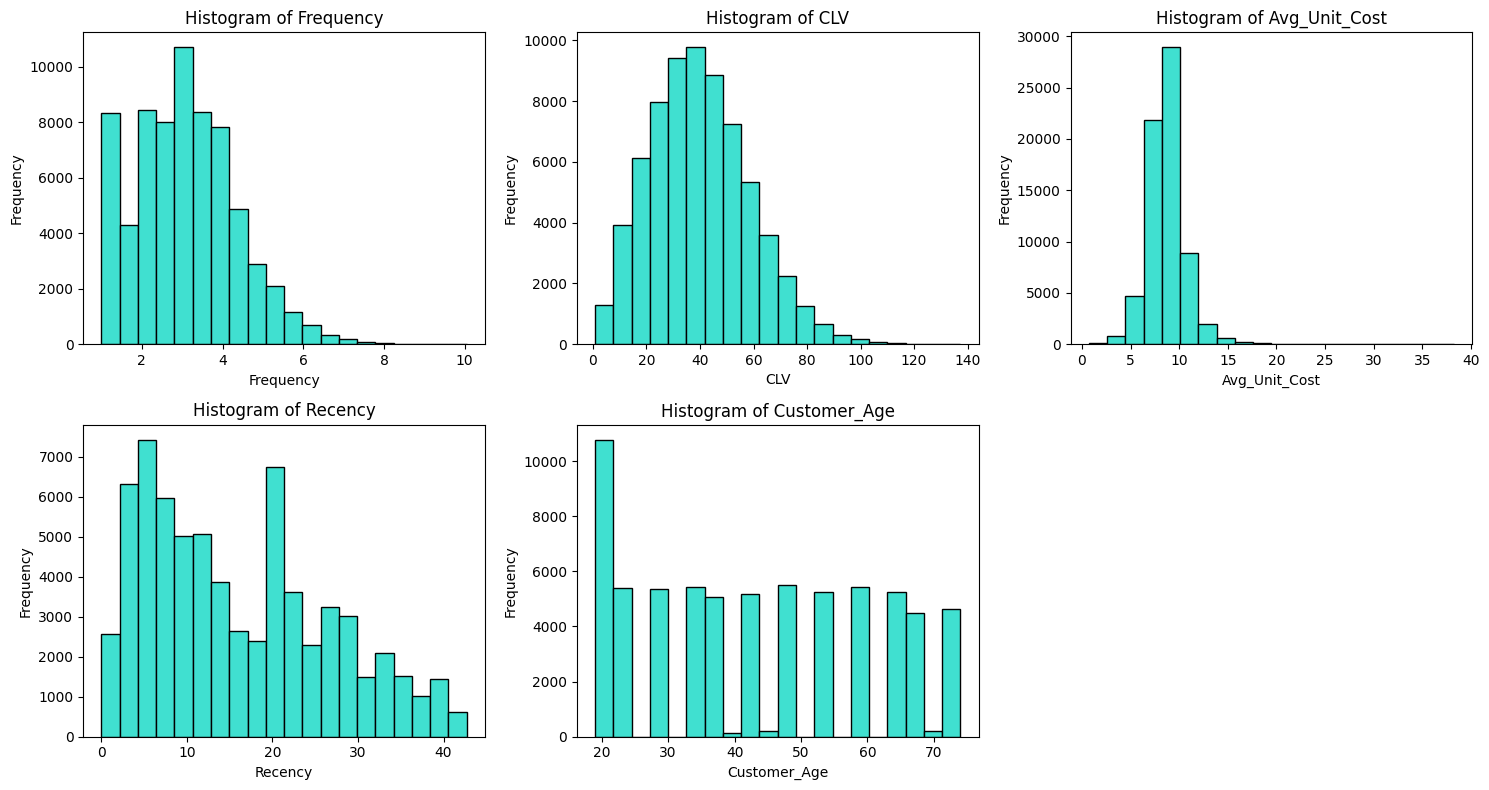

In [ ]:
# Check the distribution of transformed features
plot_feature_distributions(X_transformed)


### Results

Square root transformation successfully reduced skewness in the selected features.

## Elbow method

- **Purpose**: Compare K-Means inertia across cluster counts.  
- **Cluster Range**: Evaluate k from 1 to 20.  
- **Goal**: Identify the point where adding more clusters yields minimal improvement.


In [ ]:
def elbow_method(X_scaled, k_range=range(1, 11), random_state=SEED):
    """
    Perform the Elbow Method to determine the optimal number of clusters for KMeans.

    Parameters
    ----------
    X_scaled : numpy.ndarray
        Scaled feature array
    k_range : iterable, optional
        Range of k values (number of clusters) to evaluate. Default is range(1, 11).
    random_state : int, optional
        Random seed for reproducibility. Default is SEED.

    Returns
    -------
    None
        Displays an Elbow plot (k vs inertia).
    """

    # Compute inertia for each k
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.figure(figsize=(10,5))
    plt.plot(k_range, inertias, 'o-', color='turquoise', markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(k_range)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

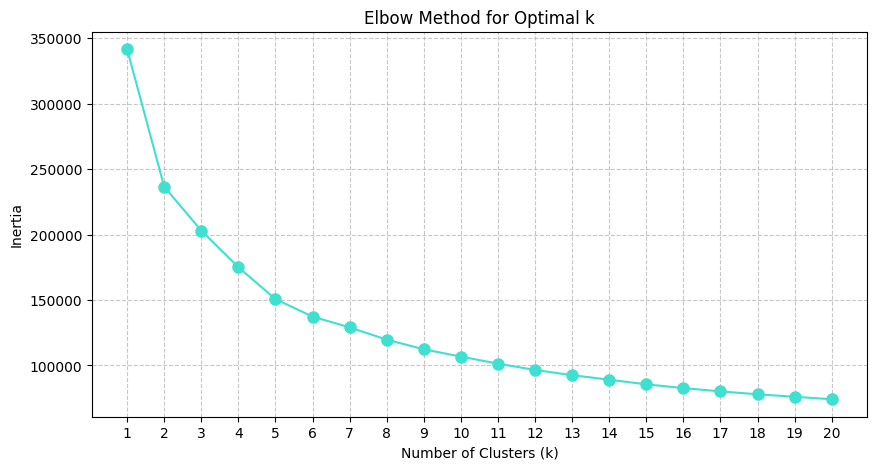

In [ ]:
elbow_method(X_scaled, k_range=range(1, 21))


### Results

While no sharp elbow is visible, inertia reductions diminish noticeably beyond five clusters, suggesting five as a reasonable choice.

## Silhouette scores

- **Purpose**: Evaluate how well each sample fits within its assigned cluster compared to other clusters.  
- **Cluster Range**: Compute average silhouette scores for cluster counts from 2 to 10.  
- **Goal**: Assess cluster cohesion and separation to guide the selection of the optimal number of clusters.


In [ ]:
def silhouette_scores(X_scaled, k_range=range(2, 11), seed=SEED, figsize=(10, 6)):
    """
    Compute and plot silhouette scores for a range of cluster counts using K-Means.

    Parameters
    ----------
    X_scaled : numpy.ndarray
        Scaled feature array for clustering.
    k_range : iterable, optional (default=range(2, 11))
        Range of cluster numbers to evaluate.
    seed : int, optional
        Random seed for KMeans reproducibility.
    figsize : tuple, optional
        Figure size for the silhouette plots.
    """

    for n_clusters in k_range:
        # Initialize the figure
        plt.figure(figsize=figsize)
        plt.xlim([-0.25, 1])
        plt.ylim([0, len(X_scaled) + (n_clusters + 1) * 10])  # Add spacing between clusters

        # Fit KMeans and predict cluster labels
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
        cluster_labels = kmeans.fit_predict(X_scaled)

        # Compute average silhouette score
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg:.3f}")

        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

        y_lower = 10  # Starting position for the first cluster
        for i in range(n_clusters):
            # Extract and sort silhouette scores for cluster i
            ith_cluster_values = np.sort(sample_silhouette_values[cluster_labels == i])
            size_cluster_i = ith_cluster_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Fill silhouette plot for cluster i
            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7
            )

            # Label cluster number at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Update y_lower for next cluster (10 units spacing)
            y_lower = y_upper + 10

        # Plot formatting
        plt.title(f"Silhouette Plot for n_clusters = {n_clusters}")
        plt.xlabel("Silhouette Coefficient")
        plt.ylabel("Cluster Label")
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Average silhouette
        plt.yticks([])  # Hide y-axis ticks

    plt.show()


For n_clusters = 2, the average silhouette_score is: 0.269
For n_clusters = 3, the average silhouette_score is: 0.239
For n_clusters = 4, the average silhouette_score is: 0.203
For n_clusters = 5, the average silhouette_score is: 0.224
For n_clusters = 6, the average silhouette_score is: 0.213
For n_clusters = 7, the average silhouette_score is: 0.213
For n_clusters = 8, the average silhouette_score is: 0.204
For n_clusters = 9, the average silhouette_score is: 0.205
For n_clusters = 10, the average silhouette_score is: 0.197


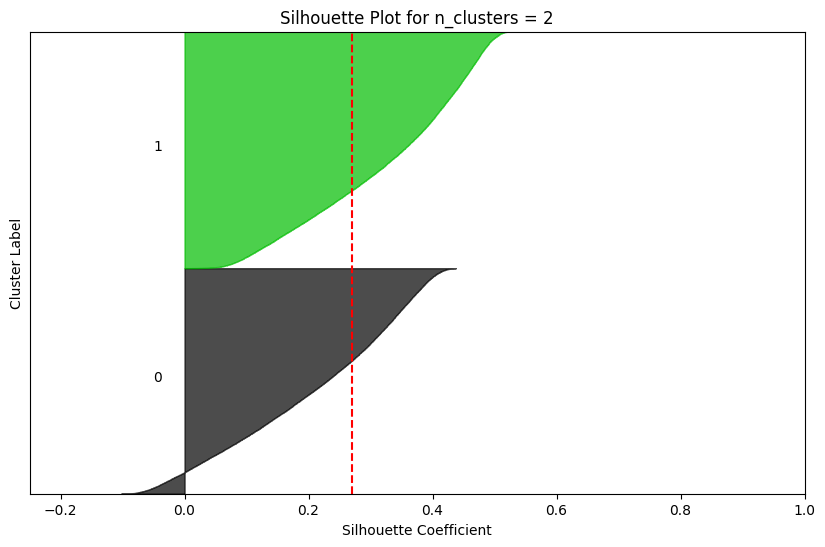

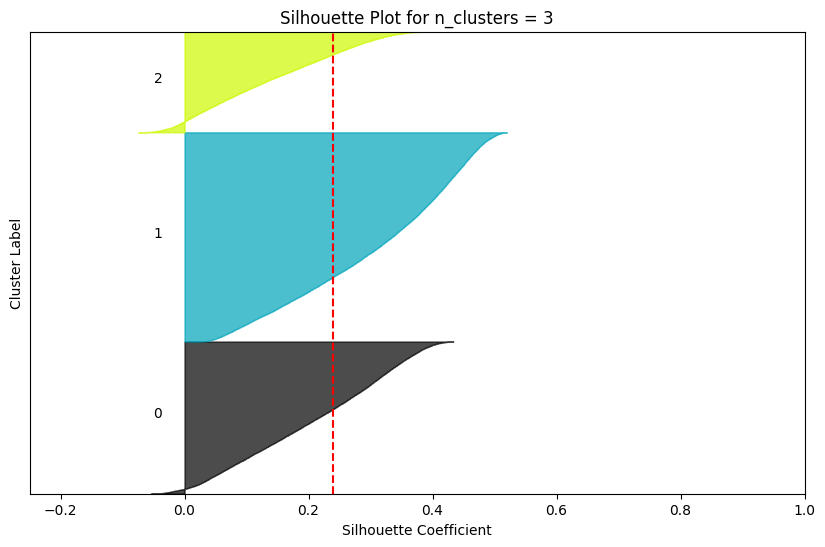

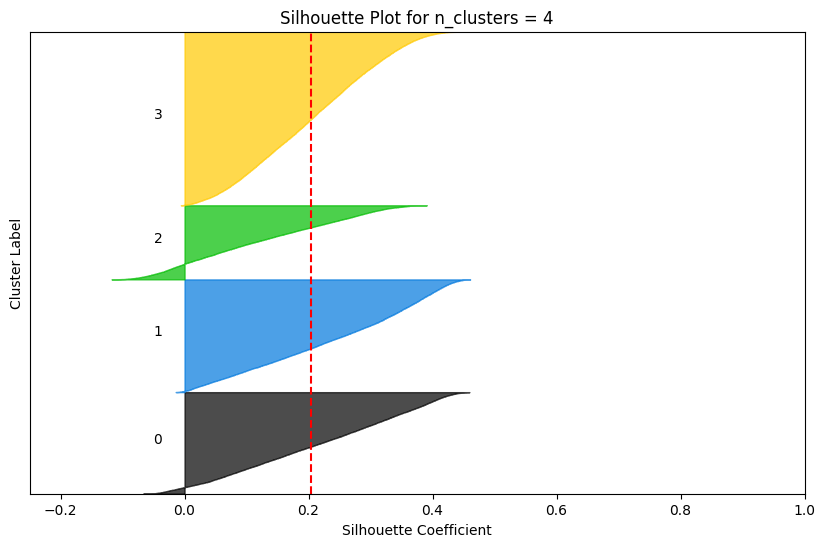

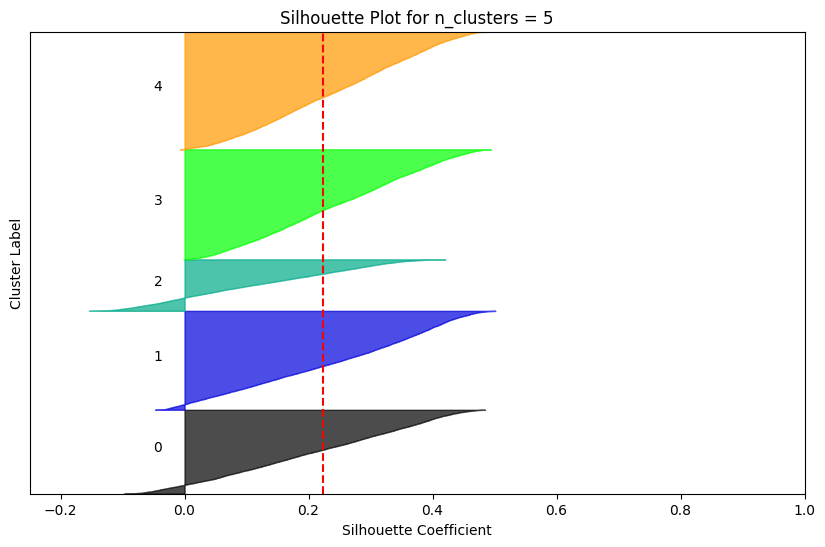

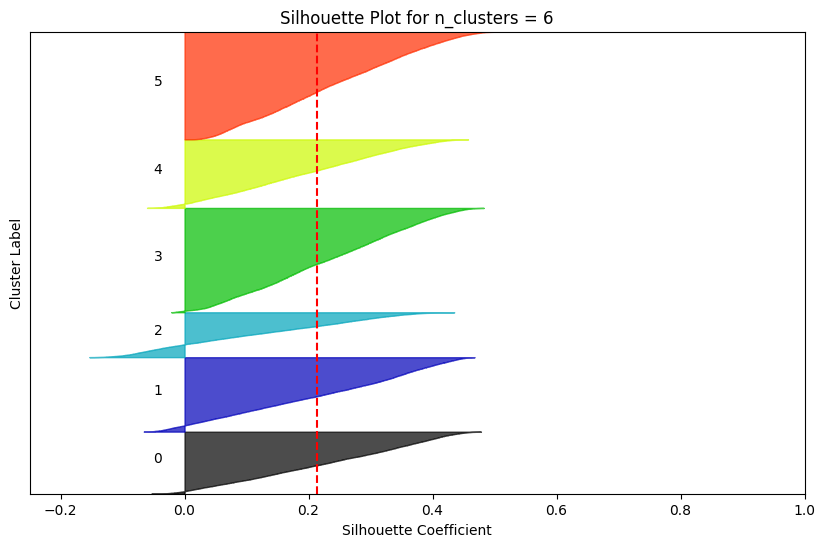

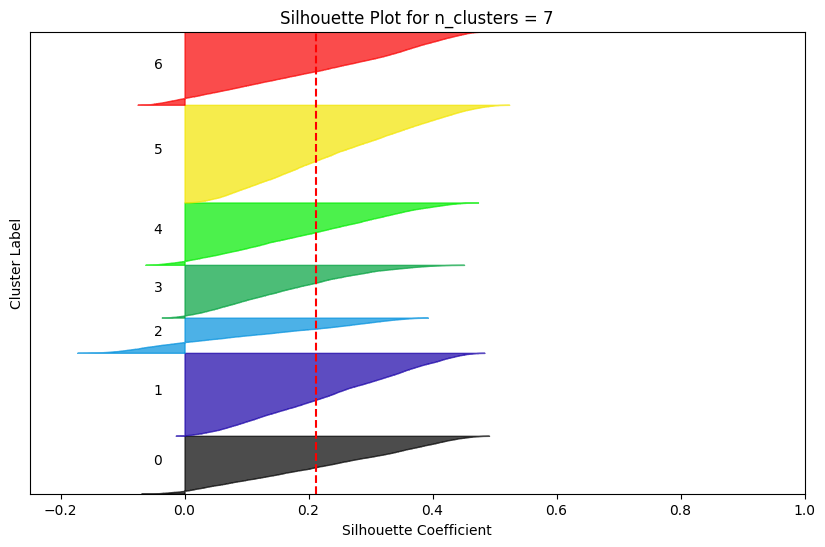

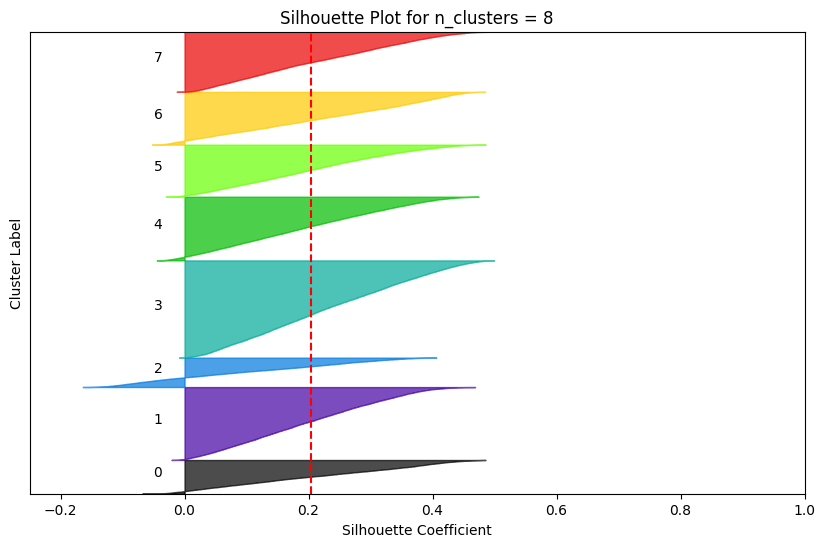

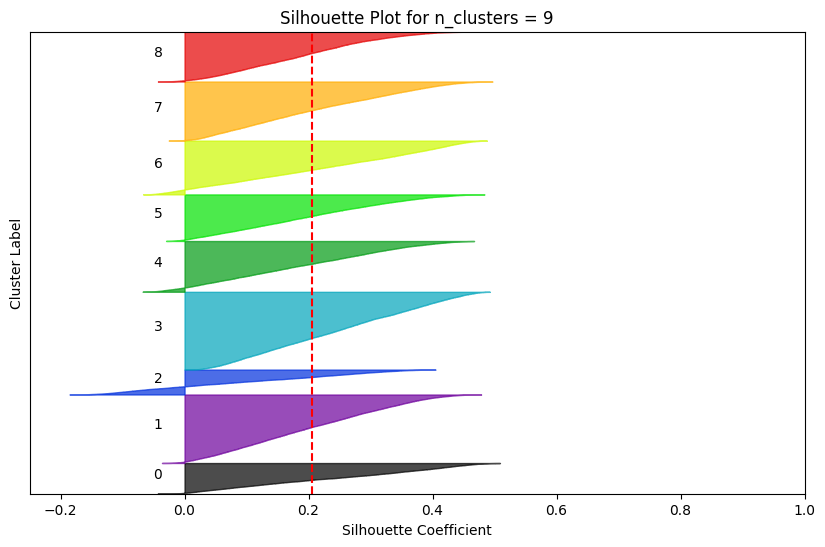

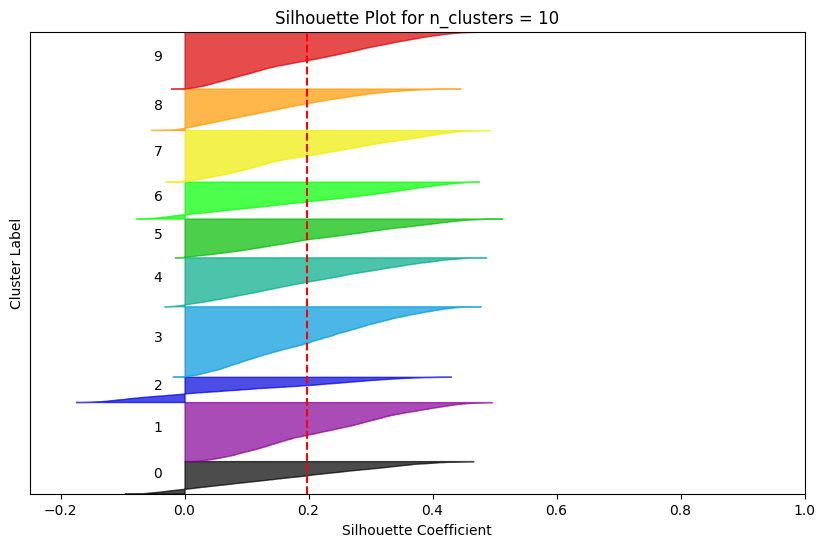

In [ ]:
silhouette_scores(X_scaled, k_range=range(2, 11))


### Results

Average silhouette scores indicate that 2, 3, and 5 clusters achieve relatively higher scores, with five clusters providing the strongest performance among solutions with more than three clusters.

## Hierarchical clustering and dendrogram

- **Hierarchical Clustering (Ward's Linkage)**: Explore hierarchical relationships between customers and guide cluster selection.  
- **Compatibility with K-Means**: Ward's method optimizes the same objective function as K-Means.  
- **Dendrogram Visualization**: Display potential cluster structures.  
- **Random Sampling**: Use a 50% random sample to reduce computational load and avoid notebook crashes.

In [ ]:
def sample_data(X, fraction, random_state=SEED):
    """
    Randomly sample a fraction of rows from an array without replacement.

    Parameters
    ----------
    X : np.ndarray
        Input data array to sample from.
    fraction : float
        Fraction of rows to sample (between 0 and 1).
    random_state : int, optional
        Seed for reproducible random sampling.

    Returns
    -------
    np.ndarray
        Subset of X containing the sampled rows.
    """
    # Initialize random number generator
    rng = np.random.default_rng(random_state)

    # Determine number of samples
    n_samples = int(fraction * X.shape[0])

    # Randomly select row indices without replacement
    indices = rng.choice(X.shape[0], size=n_samples, replace=False)

    # Return sampled rows
    return X[indices]

In [ ]:
def run_hierarchical_clustering(X_scaled, method):
    """
    Perform hierarchical clustering, display a truncated dendrogram,
    and return the linkage matrix.

    Parameters
    ----------
    X_scaled : np.ndarray
        Scaled feature matrix used for clustering.
    method : str, optional
        Linkage method for hierarchical clustering (default: 'ward').

    Returns
    -------
    linkage_matrix : np.ndarray
        The hierarchical clustering linkage matrix.
    """
    # Compute the linkage matrix
    linkage_matrix = linkage(X_scaled, method=method)

    # Create dendrogram plot
    plt.figure(figsize=(10, 5))
    dendrogram(
        linkage_matrix,
        truncate_mode='lastp',
        p=20,
        leaf_rotation=90
    )

    # Add plot labels and title
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')

    # Display the plot
    plt.show()

    return linkage_matrix

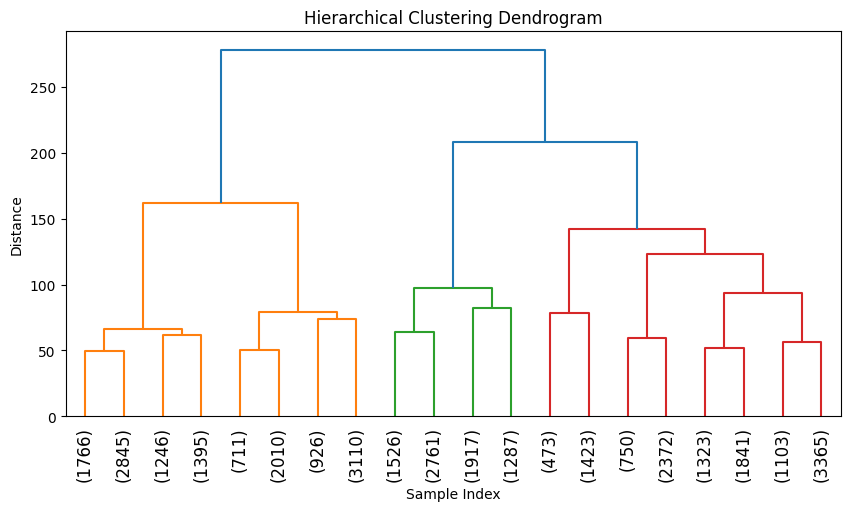

In [ ]:
# Take a 50% random sample of the scaled data to reduce memory usage
X_scaled_sampled = sample_data(X_scaled, fraction=0.5)

# Perform hierarchical clustering (Ward's linkage) on the sampled data
Z = run_hierarchical_clustering(X_scaled_sampled, method='ward')


### Results

Based on the distances observed in the dendrogram, **two to four clusters** emerge as the strongest candidates, while **five and six clusters** also appear plausible.

## Determining the optimal number of clusters

- **Final Choice**: Five clusters were selected as the most appropriate solution.  

- **Reasoning**:  
  - Avoids overly coarse segmentation associated with two or three clusters.  
  - Represents a clear inflection point in the Elbow Method analysis.  
  - Achieves the highest silhouette score among solutions with more than three clusters.  
  - Supported by the hierarchical clustering structure observed in the dendrogram.  


## K-Means clustering

- **Purpose**: Segment customers into distinct groups based on scaled features.  

- **Cluster Count**: Five clusters are used, based on prior analyses.  

- **Process**:  
  - Fit K-Means to the scaled customer features.  
  - Predict cluster labels for each customer.  
  - Increment cluster labels by 1 to label clusters as 1–5 for readability.  

- **Output**: Updated customer metrics DataFrame with cluster assignments.

In [ ]:
# Initialize K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=SEED)

# Fit K-Means to the scaled data and predict cluster labels
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to customers, incremented by 1 for easier interpretation
cluster_labels += 1
customer_metrics['Cluster'] = cluster_labels

# Preview the customer metrics with cluster assignments
customer_metrics.head()


,Customer ID,Frequency,CLV,Avg_Unit_Cost,Recency,Customer_Age,Cluster
0,1,28,4322.70,89.622857,17,63,2
1,3,14,2821.00,90.505000,124,33,2
2,4,8,782.67,37.195556,1108,33,1
3,5,15,2810.98,107.947368,5,28,2
4,6,13,1604.58,52.526667,192,58,4


# Cluster Profiling and Visualisation

- **Cluster profiling:** Analyse and compare clusters using boxplots and a summary table of median feature values.
- **PCA visualisation:** Examine cluster separation and variance structure using a 2D PCA projection.
- **t-SNE visualisation:** Explore non-linear relationships and local cluster structure using a 2D t-SNE projection.

## Cluster profiling

In [ ]:
def plot_cluster_boxplots(df, features):
    """
    Plot boxplots of selected features grouped by the 'Cluster' column to profile cluster characteristics.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the original (unscaled) features and a 'Cluster' column.
    features : list of str
        Feature names to plot.
    """
    # Create subplots
    n_features = len(features)
    fig, axes = plt.subplots(
        n_features, 1, figsize=(8, 6 * n_features), sharey=False
    )

    # Plot boxplots for each feature grouped by cluster
    for ax, feature in zip(axes, features):
        df.boxplot(
            column=feature,
            by='Cluster',
            ax=ax,
            grid=False
        )
        ax.set_title(f'{feature}', fontsize=12)
        ax.set_xlabel('Cluster', fontsize=10)
        ax.set_ylabel(feature, fontsize=10)

    # Set a main title
    fig.suptitle('Cluster Profiling: Feature Distributions by Cluster', fontsize=14)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


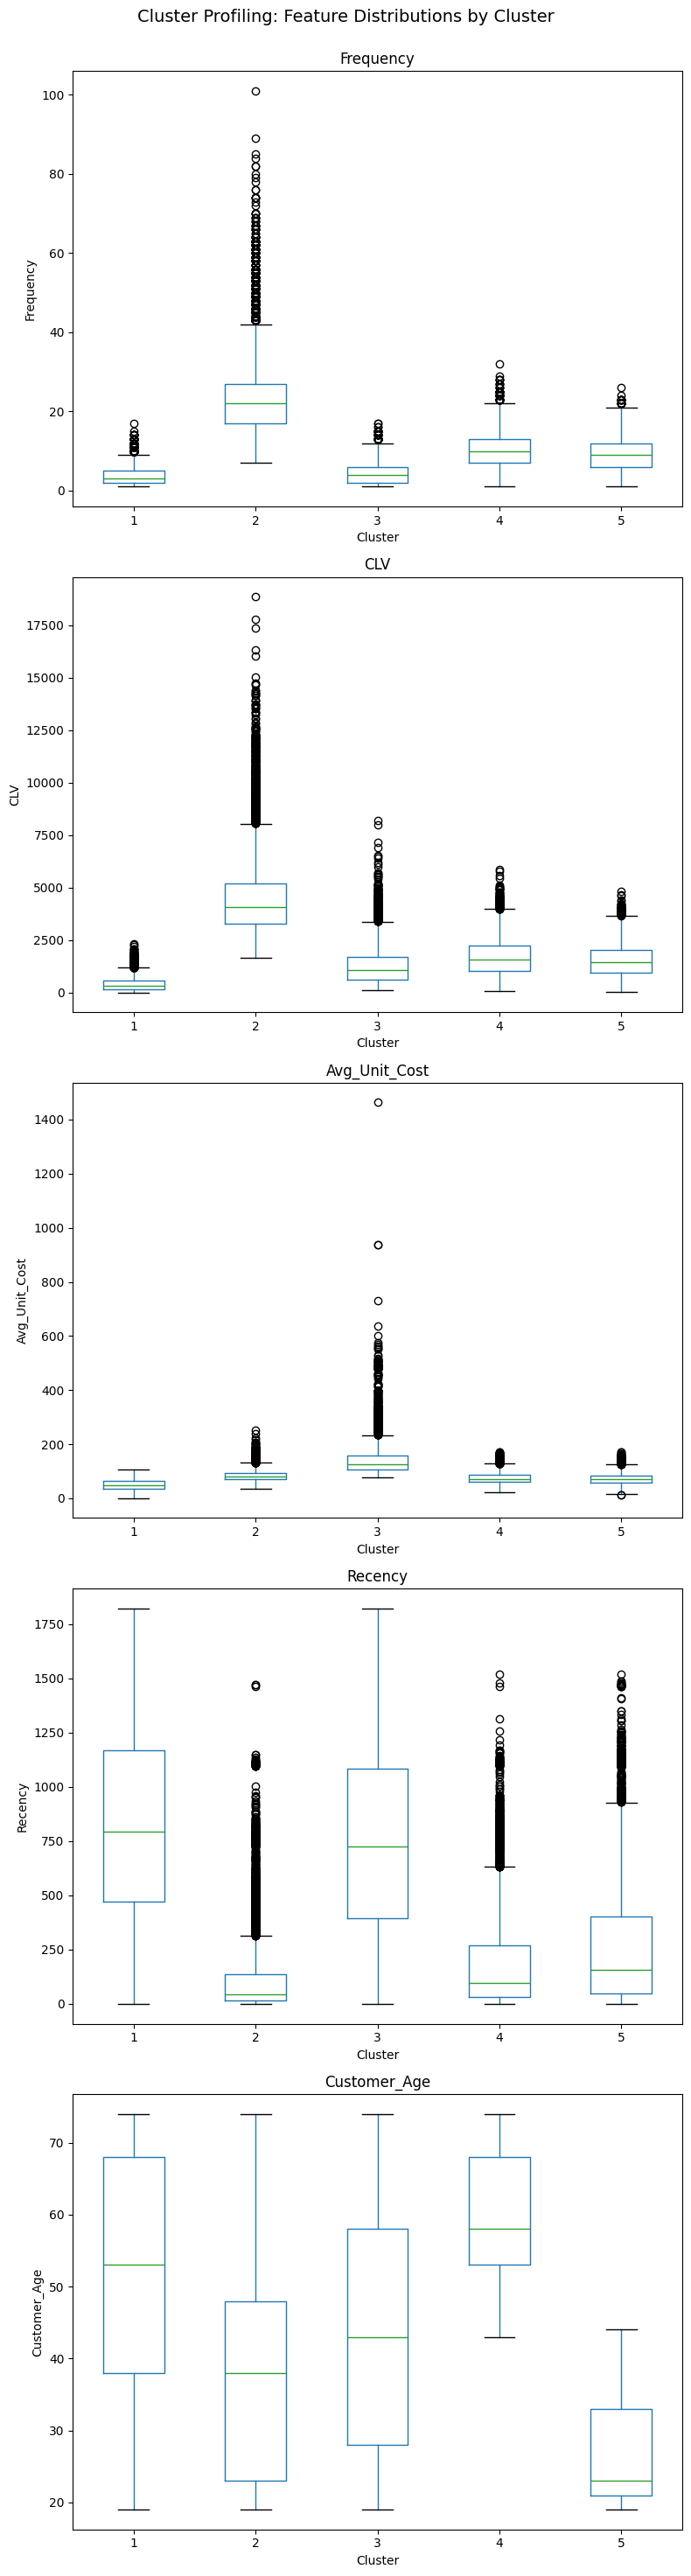

In [ ]:
# Retrieve feature names
features = X.columns
# Plot cluster boxplots
plot_cluster_boxplots(customer_metrics, features)


In [ ]:
# Compute the median of selected features for each cluster
median_summary = customer_metrics.groupby('Cluster')[features].median()

# Add the number of customers in each cluster
median_summary['Cluster_Size'] = customer_metrics.groupby('Cluster').size()

# Display the summary table
median_summary.round(2)


,Frequency,CLV,Avg_Unit_Cost,Recency,Customer_Age,Cluster_Size
Cluster,,,,,,
1,3.0,298.27,48.30,795.0,53.0,12406
2,22.0,4050.08,80.26,43.0,38.0,14629
3,4.0,1051.60,127.17,723.5,43.0,7612
4,10.0,1585.14,72.22,98.0,58.0,16272
5,9.0,1446.50,70.19,156.0,23.0,17381


### Results

- **Customer segmentation:** K-Means clustering partitions customers into five distinct groups based on their purchasing behaviour and characteristics.  

- **Cluster structure:** The segmentation reveals a clear high-value active group, a low-value inactive group, and three mid-value segments differentiated by activity patterns and age.  

- **Cluster characteristics:**  
  - **Cluster 1 – Low-value, inactive customers:** Very low frequency and CLV, highest recency (prolonged inactivity), older median age.  
  - **Cluster 2 – High-value, highly active customers:** Very high frequency and CLV, lowest recency (recent activity), younger-to-middle age range.  
  - **Cluster 3 – Low-frequency, high unit cost customers:** Lowest frequency but highest average unit cost; infrequent purchases but high spend per item.  
  - **Cluster 4 – Mid-value, older, active customers:** Older segment with moderate frequency and CLV; activity relatively recent, steady engagement.  
  - **Cluster 5 – Mid-value, young active customers:** Youngest segment with moderate frequency, CLV, and recency; reasonably active but not high-intensity purchasers.

- **Interpretability:** Together, the five clusters provide a structured and interpretable representation of customer heterogeneity.

## PCA Visualisation

In [ ]:
def plot_2d_clusters(X_2d, cluster_labels, x_label, y_label, title):
    """
    Plot a 2D projection (e.g., PCA or t-SNE).

    Parameters
    ----------
    X_2d : np.ndarray, shape (n_samples, 2)
        2D coordinates of the data.
    cluster_labels : array-like
        Cluster assignment for each sample.
    x_label : str
        Label for the x-axis.
    y_label : str
        Label for the y-axis.
    title : str
        Plot title.
    """
    # Scatter plot
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=cluster_labels,
        alpha=0.7,
        s=50
    )

    # Generate legend
    plt.legend(
        *scatter.legend_elements(),
        title="Cluster",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    # Labels and layout
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
def compute_pca_2d(X_scaled, random_state=SEED):
    """
    Compute a 2D PCA projection of scaled feature data.

    Parameters
    ----------
    X_scaled : np.ndarray
        Scaled feature matrix of shape (n_samples, n_features).
    random_state : int, optional
        Random seed for reproducibility.

    Returns
    -------
    np.ndarray
        2D PCA-transformed data of shape (n_samples, 2).
    """
    # Initialise PCA to reduce data to two principal components
    pca = PCA(n_components=2, random_state=random_state)

    # Fit PCA on the scaled data and return the 2D projection
    X_pca = pca.fit_transform(X_scaled)

    return X_pca


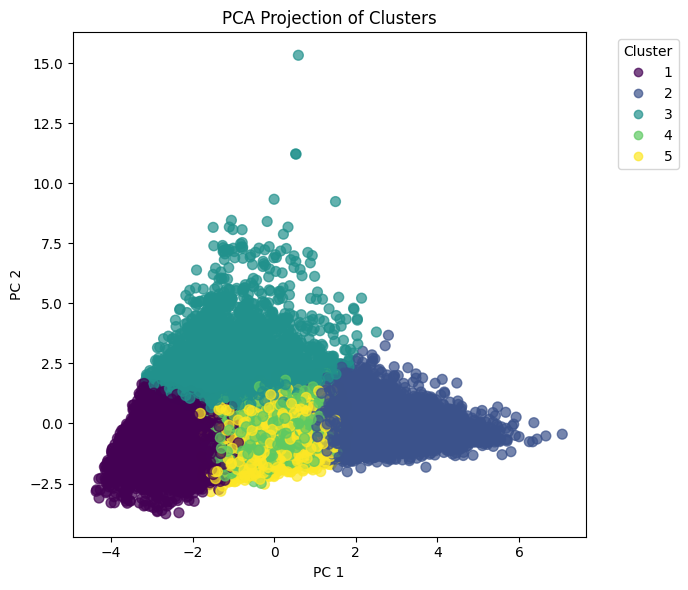

In [ ]:
X_pca = compute_pca_2d(X_scaled)
plot_2d_clusters(
    X_pca,
    cluster_labels,
    x_label='PC 1',
    y_label='PC 2',
    title='PCA Projection of Clusters',
)

## t-SNE Visualisation

In [ ]:
def compute_tsne_2d(X_scaled, perplexity=30, random_state=SEED):
    """
    Compute a 2D t-SNE projection of scaled feature data.

    Parameters
    ----------
    X_scaled : array-like, shape (n_samples, n_features)
        Scaled feature array for t-SNE projection.
    perplexity : float, optional (default=30)
        t-SNE perplexity parameter controlling local vs. global structure.
    random_state : int, optional
        Random seed for reproducibility.

    Returns
    -------
    X_tsne : ndarray, shape (n_samples, 2)
        2D t-SNE coordinates for each sample.
    """
    # Initialize t-SNE with 2 components
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=random_state
    )

    # Fit t-SNE to the data and transform into 2D
    X_tsne = tsne.fit_transform(X_scaled)
    return X_tsne

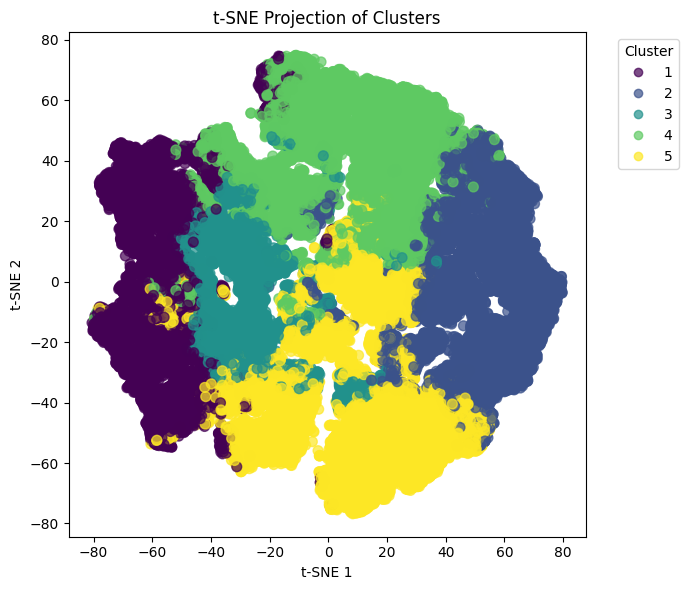

In [ ]:
X_tsne = compute_tsne_2d(X_scaled, perplexity=200)
plot_2d_clusters(
    X_tsne,
    cluster_labels,
    x_label='t-SNE 1',
    y_label='t-SNE 2',
    title='t-SNE Projection of Clusters',
)

## Results

- **Dimensionality reduction:** PCA and t-SNE are used to visualise the clustering results in 2D space.  

- **PCA visualisation:** Shows moderate separation across principal components but substantial overlap remains, particularly between clusters 3 and 4, reflecting similarity in key features and limitations of linear projections.  

- **t-SNE visualisation:** Reveals more complex, non-linear structure with fragmented cluster shapes and significant overlap, consistent with its focus on preserving local neighbourhoods rather than global separation.  

- **Overall insight:** Neither method produces clearly isolated clusters, indicating a dense and continuous customer space and highlighting the limits of 2D projections for confirming cluster validity in this case.

# Conclusions

- **Feature engineering:** Customer-level metrics (Frequency, Recency, CLV, Average Unit Cost, Customer Age) were derived to capture purchasing behaviour.
- **Feature transformation and scaling:** Applied square root transformation and scaling to reduce skewness and standardize features for clustering.
- **Cluster number determination:** Used Elbow Method, Silhouette Score, and Hierarchical Clustering/Dendrogram analyses to identify the optimal number of clusters.   
- **Segmentation approach:** K-Means clustering effectively grouped customers into five interpretable segments.  
- **Cluster profiling:** Boxplots and median summaries highlighted distinct behavioural and demographic characteristics.  
- **2D visualisation:** PCA and t-SNE provided insights into cluster structure, revealing overlaps and a dense, continuous customer space.  
- **Insights for the client:** Segmentation identifies high-value active, low-value inactive, and mid-value subgroups, supporting targeted marketing and engagement strategies.  
- **Opportunities for improvement:** Engage with the business team to refine features or incorporate additional behavioural/contextual data, potentially exploring alternative clustering methods or hybrid approaches for clearer separation.

# Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].